In [1]:
import numpy as np
import scprep
import torch
from torch_geometric.nn import knn_graph
from torch_scatter import scatter_add

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops12split_Tensor4callERKNS_6TensorEN3c106SymIntEl
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.con

In [2]:
data = np.load('../data/eb_subset_all.npz')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

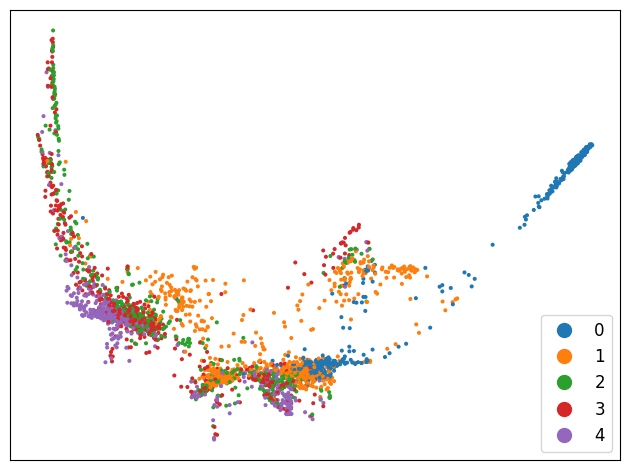

In [3]:
scprep.plot.scatter2d(data['phate'], c=data['colors'], ticks=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
points = torch.tensor(data['phate'], device=device, dtype=torch.float32)

In [5]:
class CvxHullGenDirichlet():
    def __init__(self, k=10, alpha=1., sigma=0.1, p=0.3):
        self.k = k
        self.alpha = alpha
        self.sigma = sigma
        self.p = p
        self.is_fit_ = False
        
    def fit(self, points):
        self.points = points
        self.device = points.device
        points = points.cpu()
        self.edge_index = knn_graph(points, self.k, loop=False).to(self.device)
        self.is_fit_ = True

    def generate(self, n_samples):
        assert self.is_fit_
        # randomly selecting reference neighbours
        weights = torch.ones(self.points.size(0), dtype=torch.float, device=self.device)
        indices = torch.multinomial(weights, n_samples, replacement=True)
        # generate a Dirichlet distribution of coefficients
        alpha_tensor = (torch.ones(self.k)*self.alpha).to(device)
        coefficients = torch.distributions.Dirichlet(alpha_tensor).sample((n_samples,))
        # add Gaussian noise to the coefficients

        filtered_edge_index, filtered_points = self.filter_edge_index_points(indices, self.edge_index, self.points)
        bernoulli_dist = torch.distributions.Bernoulli(self.p)
        berns = bernoulli_dist.sample(coefficients.size()).to(self.device)
        berns[berns.sum(axis=1)==0, 0] = 1
        coefficients = coefficients * berns
        coefficients = coefficients / coefficients.sum(axis=1, keepdim=True)
        noise = torch.randn_like(coefficients) * self.sigma
        coefficients += noise
        coef_flat = coefficients.view(-1)        
        generated = scatter_add((self.points[filtered_edge_index[0],:].T * coef_flat), filtered_edge_index[1]).T
        return generated

    def filter_edge_index_points(self, indices, edge_index, points):
        filtered_edge_index = []
        for i in range(len(indices)):
            sub_edge_index = edge_index[:,edge_index[1,:] == indices[i]]
            sub_edge_index[1,:] = i
            filtered_edge_index.append(sub_edge_index)
        filtered_edge_index = torch.cat(filtered_edge_index, dim=1)
        filtered_points = points[indices]
        return filtered_edge_index, filtered_points

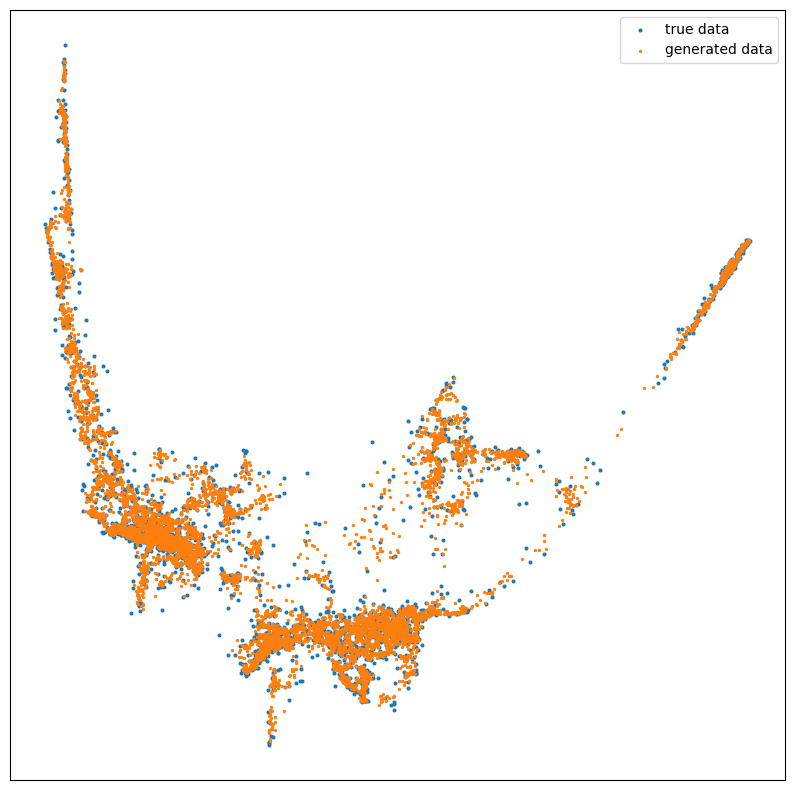

In [24]:
import matplotlib.pyplot as plt
generator = CvxHullGenDirichlet(k=10, alpha=1., sigma=0., p=.5)
generator.fit(points)
gen_pts = generator.generate(10000)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scprep.plot.scatter2d(points.cpu().numpy(), ticks=False, ax=ax, label='true data')
scprep.plot.scatter2d(gen_pts.cpu().numpy(), ticks=False, ax=ax, label='generated data')
plt.legend()

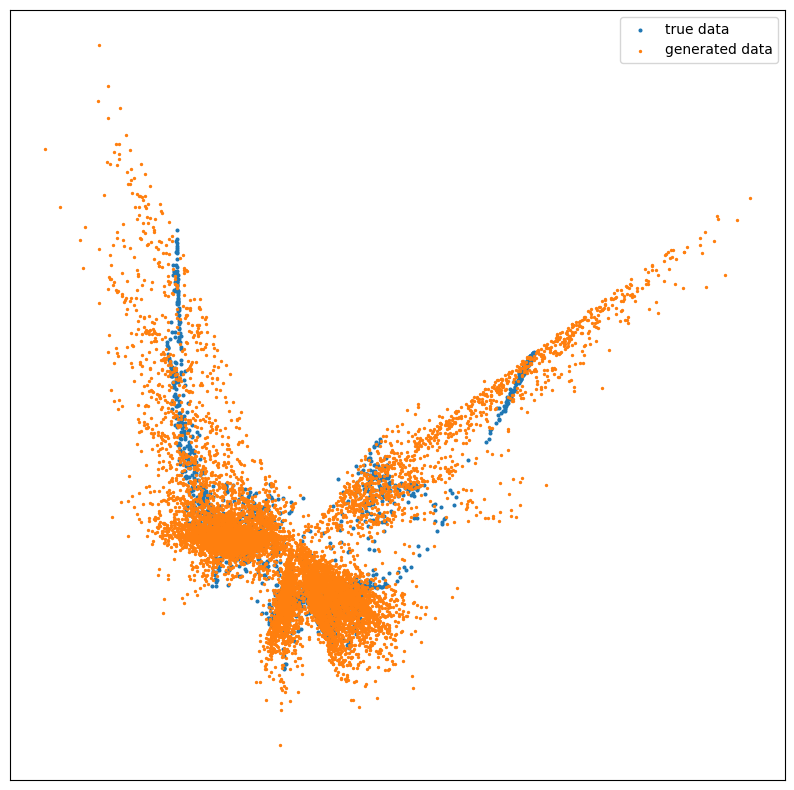

In [7]:
import matplotlib.pyplot as plt
generator = CvxHullGenDirichlet(k=10, alpha=1., sigma=0.1, p=.1)
generator.fit(points)
gen_pts = generator.generate(10000)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scprep.plot.scatter2d(points.cpu().numpy(), ticks=False, ax=ax, label='true data')
scprep.plot.scatter2d(gen_pts.cpu().numpy(), ticks=False, ax=ax, label='generated data')
plt.legend()

In [8]:
class CvxHullGen():
    def __init__(self, k=10, alpha=1., sigma=0.1, p=0.3, delta=0.1):
        self.k = k
        self.alpha = alpha
        self.sigma = sigma
        self.p = p
        assert delta <= 1 and delta >= 0
        self.delta = delta
        self.is_fit_ = False
        
    def fit(self, points):
        self.points = points
        self.device = points.device
        points = points.cpu()
        self.edge_index = knn_graph(points, self.k, loop=False).to(self.device)
        self.is_fit_ = True

    def generate(self, n_samples):
        assert self.is_fit_
        # randomly selecting reference neighbours
        weights = torch.ones(self.points.size(0), dtype=torch.float, device=self.device)
        indices = torch.multinomial(weights, n_samples, replacement=True)
        coefficients = torch.rand(n_samples, self.k, device=self.device)
        coefficients = coefficients * (1 + 2 * self.delta) - self.delta
        coefficients[:,-1] = coefficients[:,:-1].sum(axis=1)
        filtered_edge_index, filtered_points = self.filter_edge_index_points(indices, self.edge_index, self.points)
        bernoulli_dist = torch.distributions.Bernoulli(self.p)
        berns = bernoulli_dist.sample(coefficients.size()).to(self.device)
        berns[berns.sum(axis=1)==0, 0] = 1
        coefficients = coefficients * berns
        coefficients = coefficients / coefficients.sum(axis=1, keepdim=True)
        noise = torch.randn_like(coefficients) * self.sigma
        coefficients *= 1+noise
        coef_flat = coefficients.view(-1)        
        generated = scatter_add((self.points[filtered_edge_index[0],:].T * coef_flat), filtered_edge_index[1]).T
        return generated

    def filter_edge_index_points(self, indices, edge_index, points):
        filtered_edge_index = []
        for i in range(len(indices)):
            sub_edge_index = edge_index[:,edge_index[1,:] == indices[i]]
            sub_edge_index[1,:] = i
            filtered_edge_index.append(sub_edge_index)
        filtered_edge_index = torch.cat(filtered_edge_index, dim=1)
        filtered_points = points[indices]
        return filtered_edge_index, filtered_points

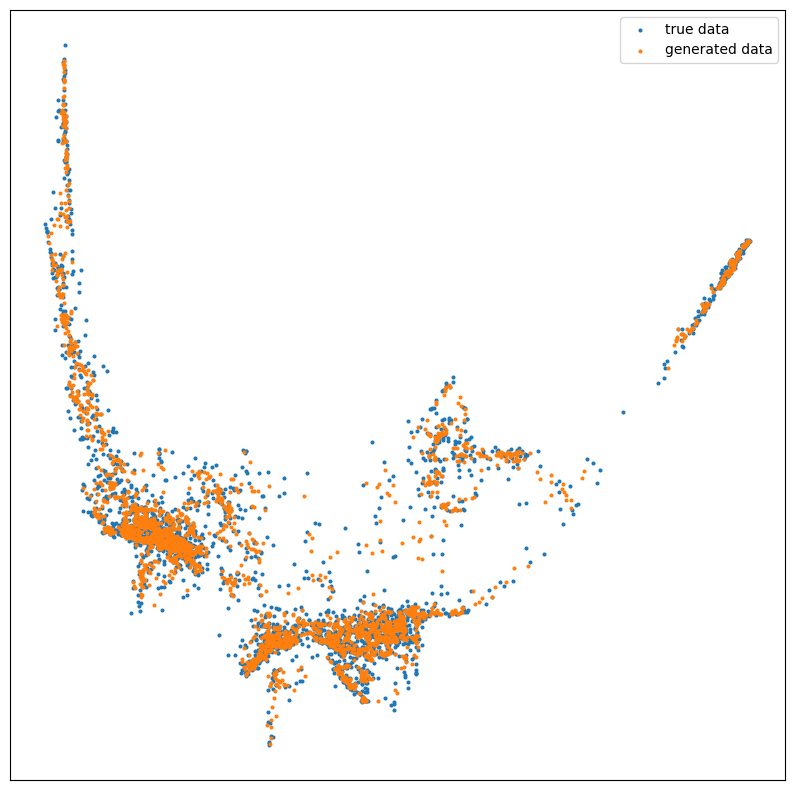

In [21]:
import matplotlib.pyplot as plt
generator = CvxHullGen(k=10, delta=0.2, sigma=0., p=.5)
generator.fit(points)
gen_pts = generator.generate(3000)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scprep.plot.scatter2d(points.cpu().numpy(), ticks=False, ax=ax, label='true data')
scprep.plot.scatter2d(gen_pts.cpu().numpy(), ticks=False, ax=ax, label='generated data')
plt.legend()